<a href="https://colab.research.google.com/github/binodrimal/genetic_stock_agents/blob/main/Genetic_Stock_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/binodrimal/genetic_stock_agents
from genetic_stock_agents import *

  Cloning https://github.com/binodrimal/genetic_stock_agents to /tmp/pip-req-build-pifgrhv6
  Running command git clone -q https://github.com/binodrimal/genetic_stock_agents /tmp/pip-req-build-pifgrhv6
  Created wheel for ImportGeneticStockAgent: filename=ImportGeneticStockAgent-0.0.1-py3-none-any.whl size=1939 sha256=6b354a880e0a5e620b80c9f86e451a576a3e0b4002b711dbb743852153ddc348
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss0je_1s/wheels/4d/18/33/22d1401535047cbf9c1587317e7b48fd415712d449deb8b237
Successfully built ImportGeneticStockAgent


In [2]:
df_original=get_data(ticker,'2000-01-01', date.today().strftime("%Y-%m-%d"),'1d')

[*********************100%***********************]  505 of 505 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [3]:
df = df_original.copy()

In [4]:
df = df["Close"]

In [5]:
df_original.shape

(5444, 2526)

In [6]:
df.shape

(5444, 505)

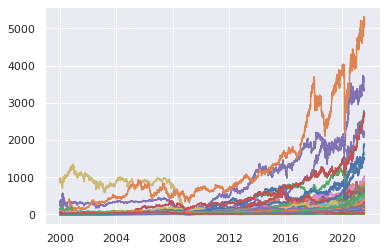

In [7]:
for i in range(len(list(df.keys()))):
  plt.plot(df[df.keys()[i]])

In [8]:
data1 = np.zeros(df.shape)

In [9]:
for i in range(len(list(df.keys()))):
  data1[:,i] = (df[df.keys()[i]])

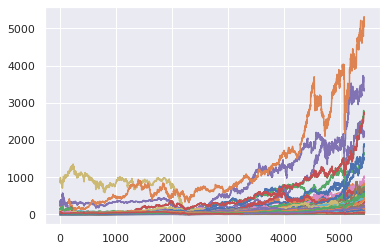

In [10]:
for i in range(len(list(df.keys()))):
  plt.plot(data1[:,i])

In [11]:
data1

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [ 44.40432358,          nan,          nan, ...,  25.02777863,
         39.50033951,          nan],
       [ 41.01232147,          nan,          nan, ...,  24.66666603,
         37.58759689,          nan],
       ...,
       [155.69999695,  21.02000046, 205.72000122, ..., 562.27001953,
         54.99000168, 201.88000488],
       [156.53999329,  20.55999947, 204.52000427, ..., 563.97998047,
         54.54999924, 199.72000122],
       [156.52000427,  20.94000053, 208.74000549, ..., 567.10998535,
         55.31999969, 198.75999451]])

In [12]:
r = np.random.permutation(data1.shape[1])

In [13]:
data2 = data1[:,r]

In [14]:
Time_Split = data2.shape[0]//2
Ticker_Split = data2.shape[1]//2

In [174]:
train_data = data2[0:Time_Split,0:Ticker_Split]
test_data  = data2[Time_Split:,Ticker_Split:]

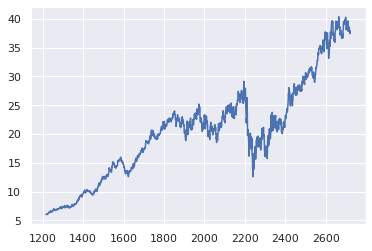

In [175]:
plt.plot(train_data[:,100])

In [176]:
import torch

In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [178]:
device

device(type='cuda')

In [179]:
# Activation Function
# argmax() returns the indices of the maximum values along an axis (axis =1,row).
# af() returns either 1 or -1 in our case( i.e array with 2 rows)
def af(x):
    return torch.argmax(x,1).to(float) - 1

In [180]:
def remove_nan(data):
  mask = np.isnan(data)
  data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
  return data

In [181]:
train_data = remove_nan(train_data)
test_data = remove_nan(test_data)

In [182]:
# train_data = np.nan_to_num(train_data, nan=0)
# test_data = np.nan_to_num(test_data, nan=0)

In [183]:
torch.tensor(train_data,device=device)

tensor([[ 8.9878, 57.9715, 34.0725,  ..., 10.0525, 30.0593, 30.2160],
        [ 8.9878, 57.9715, 34.0725,  ..., 10.0525, 30.0593, 30.2160],
        [ 8.8247, 56.2130, 33.1320,  ..., 10.0525, 29.4809, 29.7963],
        ...,
        [25.8657, 10.4665,  8.3596,  ..., 24.9241, 45.1823, 68.1459],
        [25.9075, 10.5697,  8.3283,  ..., 25.4765, 45.6666, 68.7587],
        [25.8726, 10.5791,  8.4309,  ..., 25.4258, 45.7675, 69.0388]],
       device='cuda:0', dtype=torch.float64)

In [184]:
def marketms(d,w,window=75,order_size=10,starting_captial=10_000,return_extras=False):
    N = w.shape[0]
    signal = torch.zeros((N,d.shape[0],d.shape[1]),device=device)
    current_shares = torch.zeros((N,d.shape[1]),device=device)
    balance = torch.zeros((N,d.shape[1]),device=device) + starting_captial
    
    for i in range(window,len(d)):

        dw = d[(i)-window:i]

        dw = (dw-torch.mean(dw))/torch.std(dw) # Normalize data

        signal[:,i] = af(torch.matmul(w,dw))
        # agent will learn w to decide whether to buy or sell within the window

        balance -= (signal[:,i]  ==  1)*(balance >= order_size*d[i])*order_size*d[i]
        current_shares += (signal[:,i]  ==  1)*(balance >= order_size*d[i])*order_size

        balance += (signal[:,i]  == -1)*(current_shares >= order_size)*order_size*d[i]
        current_shares -= (signal[:,i]  == -1)*(current_shares >= order_size)*order_size

    
    gain = balance + current_shares*d[-1] - starting_captial

    if return_extras:
      return gain,signal,current_shares,balance
    else:
      return gain

In [203]:
N = 20
w = 0.1*torch.randn(N,3,75, device=device, dtype=torch.double) # [Agent, {buy, nop, sell}, offset]

In [204]:
gain_train,signal,current_shares,balance = marketms(torch.tensor(train_data,device=device),w,window=75,order_size=10,return_extras=True)

In [187]:
gain_test,signal,current_shares,balance = marketms(torch.tensor(test_data,device=device),w,window=75,order_size=10,return_extras=True)

In [208]:
for i in range(15):

    #Get Fitness
    gain_train,signal,current_shares,balance = marketms(torch.tensor(train_data,device=device),w,window=75,order_size=10,return_extras=True)

    gains_train = torch.sum(gain_train,1)

    #Sort Agents
    w = w[torch.argsort(gains_train,descending=True)]

    #Copy Best Agent Weights
    w[N//2:] = w[:N//2]

    #Mutate Agents
    w[N//2:] += 0.01*torch.randn(N//2,3,75, device=device, dtype=torch.double)

    print(i,torch.sum(gains_train))

0 tensor(24531975.2584, device='cuda:0', dtype=torch.float64)
1 tensor(53313646.5456, device='cuda:0', dtype=torch.float64)
2 tensor(94241582.3827, device='cuda:0', dtype=torch.float64)
3 tensor(99771877.3200, device='cuda:0', dtype=torch.float64)
4 tensor(1.0118e+08, device='cuda:0', dtype=torch.float64)
5 tensor(1.0352e+08, device='cuda:0', dtype=torch.float64)
6 tensor(1.0383e+08, device='cuda:0', dtype=torch.float64)
7 tensor(1.0475e+08, device='cuda:0', dtype=torch.float64)
8 tensor(1.0496e+08, device='cuda:0', dtype=torch.float64)
9 tensor(1.0527e+08, device='cuda:0', dtype=torch.float64)
10 tensor(1.0572e+08, device='cuda:0', dtype=torch.float64)
11 tensor(1.0554e+08, device='cuda:0', dtype=torch.float64)
12 tensor(1.0563e+08, device='cuda:0', dtype=torch.float64)
13 tensor(1.0585e+08, device='cuda:0', dtype=torch.float64)
14 tensor(1.0547e+08, device='cuda:0', dtype=torch.float64)


In [209]:
agent_rank = torch.argsort(gains_train,descending=True)
signal = signal[agent_rank]
gains = gain_train[agent_rank]
w = w[agent_rank]

In [217]:
agent_num = 0 
stock_num = 14

In [237]:
d = train_data[:,stock_num]

In [239]:
signal.shape

torch.Size([20, 2722, 252])

In [240]:
s = signal[agent_num,:,stock_num].cpu().numpy()

In [241]:
s.shape

(2722,)

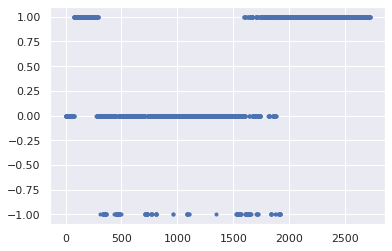

In [242]:
plt.plot(s,'.')

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


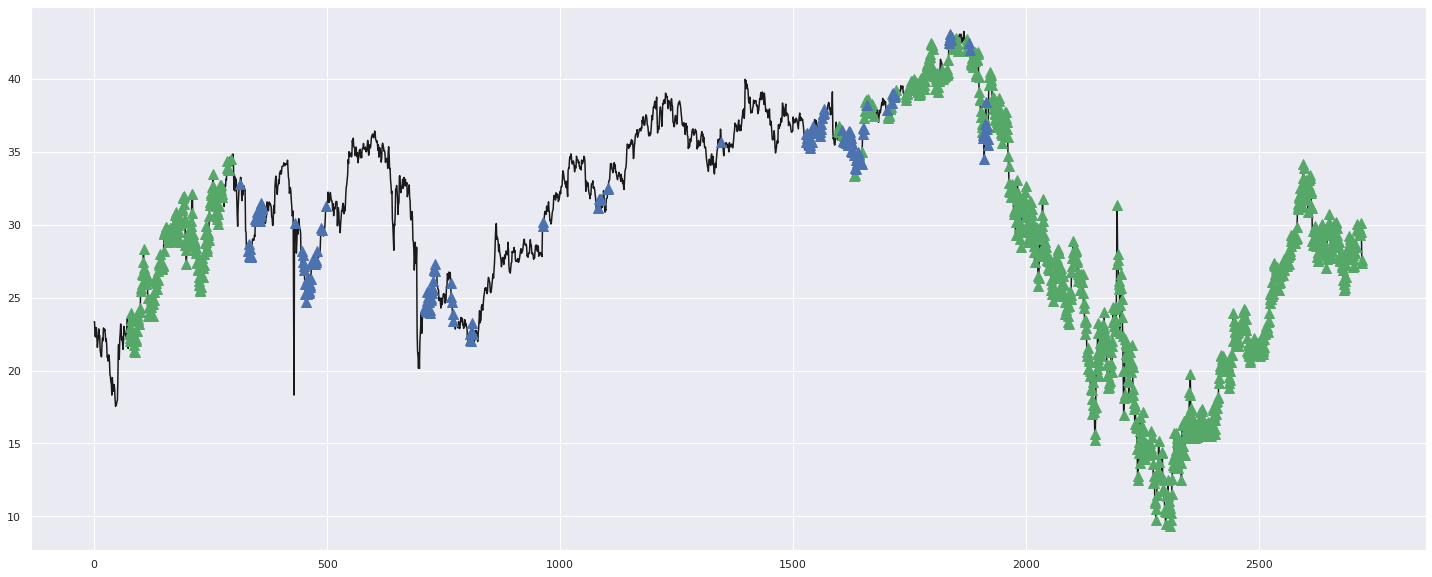

In [255]:
fig = plt.figure(figsize = (25,10))
plt.plot(d,'k')
plt.plot(d,'g^', markersize=10, markevery = [s==1] )
plt.plot(d,'b^', markersize=10, markevery = [s==-1] )

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


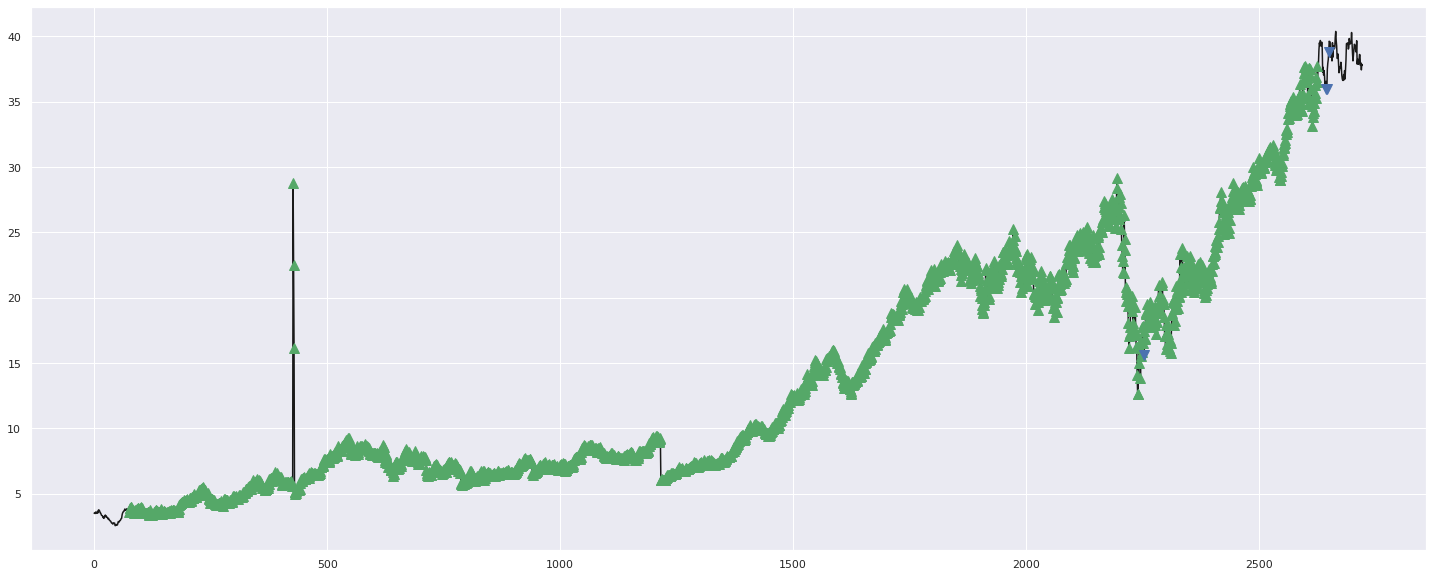

In [263]:
agent_num = 12 
stock_num = 100
d = train_data[:,stock_num]
s = signal[agent_num,:,stock_num].cpu().numpy()

fig = plt.figure(figsize = (25,10))
plt.plot(d,'k')
plt.plot(d,'g^', markersize=10, markevery = [s == 1] )
plt.plot(d,'bv', markersize=10, markevery = [s== -1] )

In [ ]:
############################
############################
############################
############################
############################

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


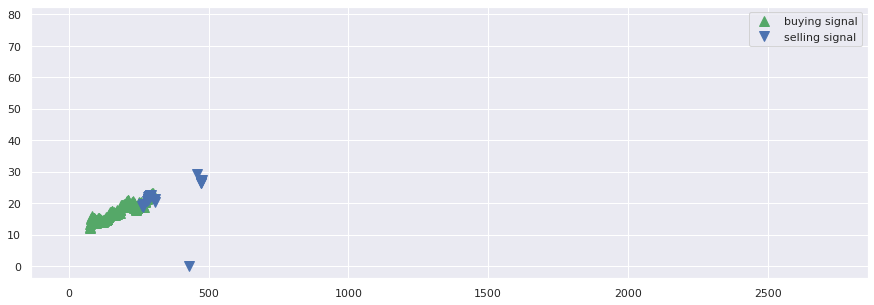

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


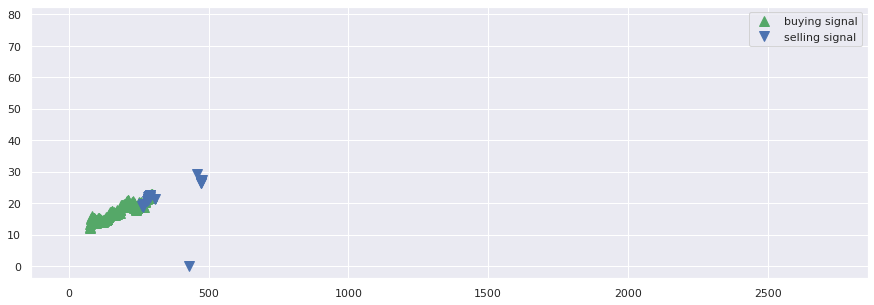

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


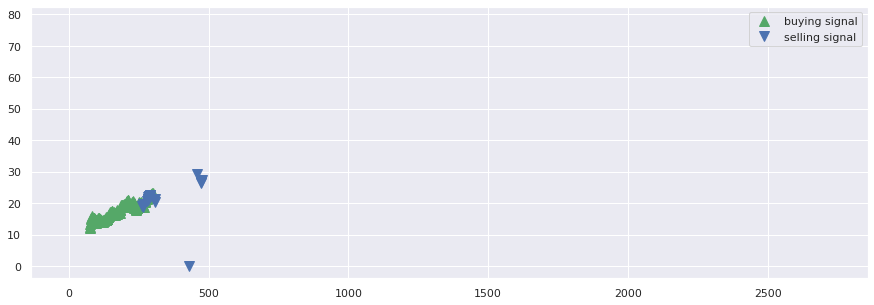

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


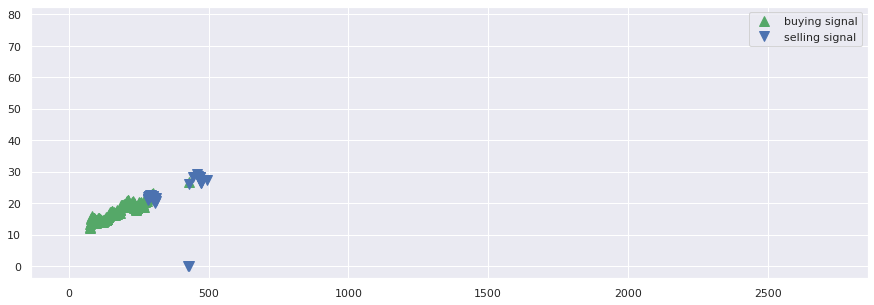

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


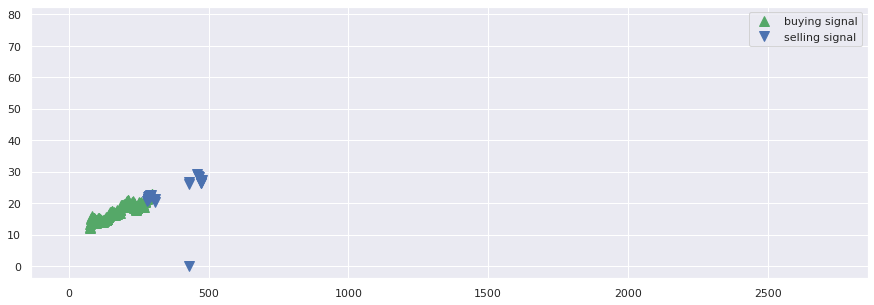

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


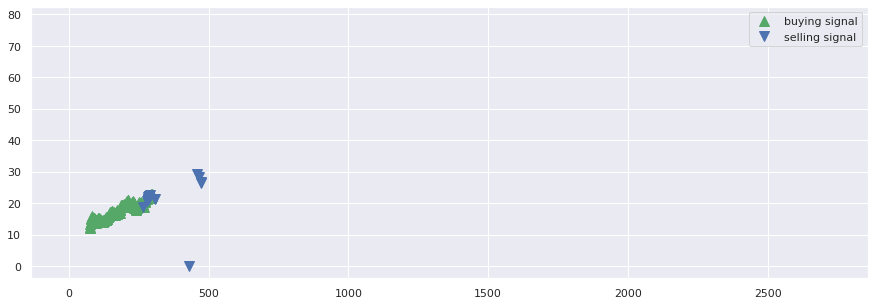

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


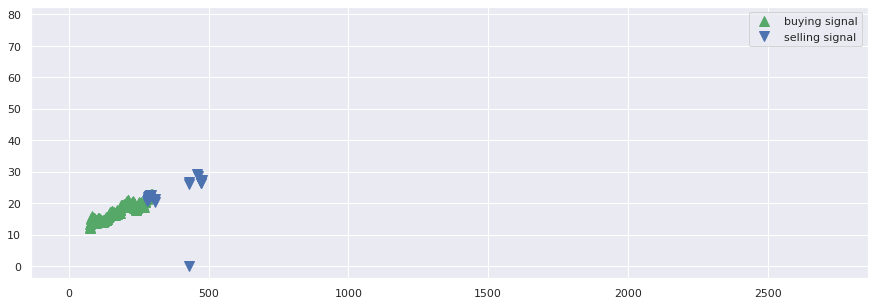

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


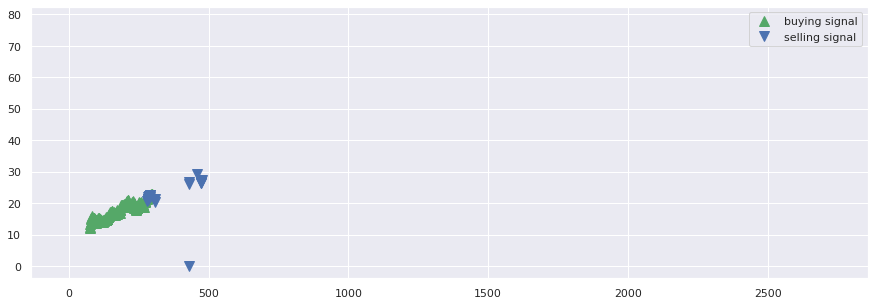

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


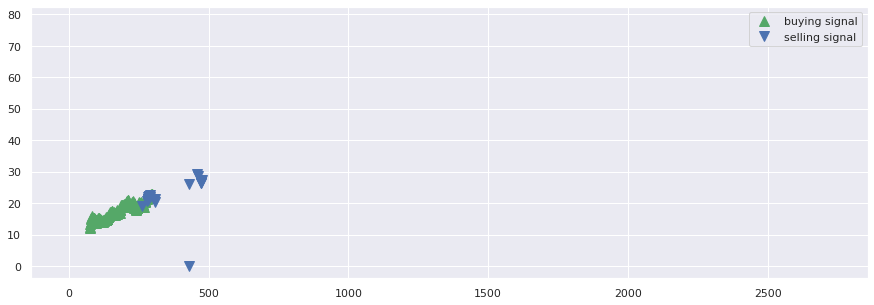

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


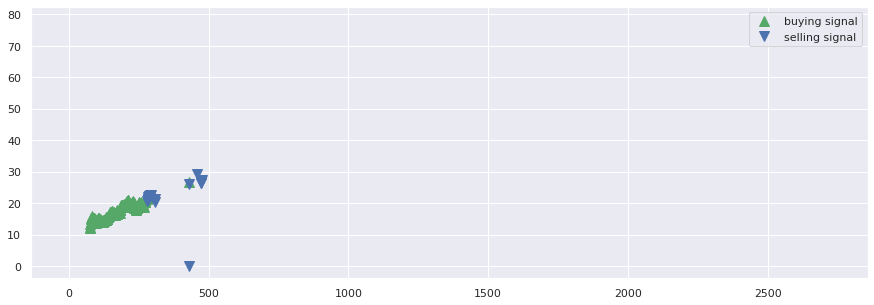

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


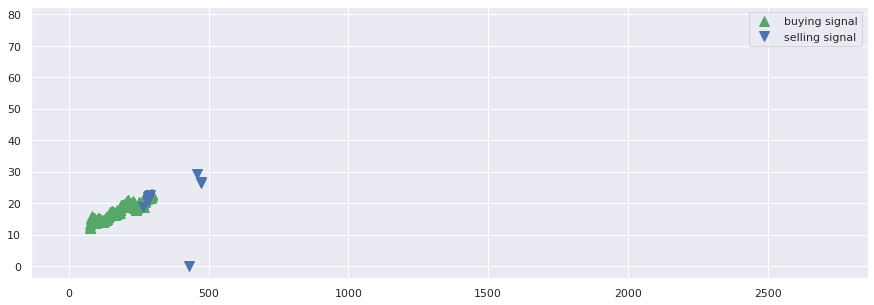

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


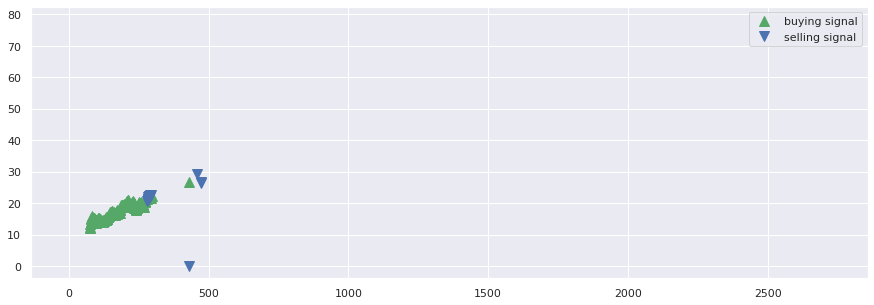

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


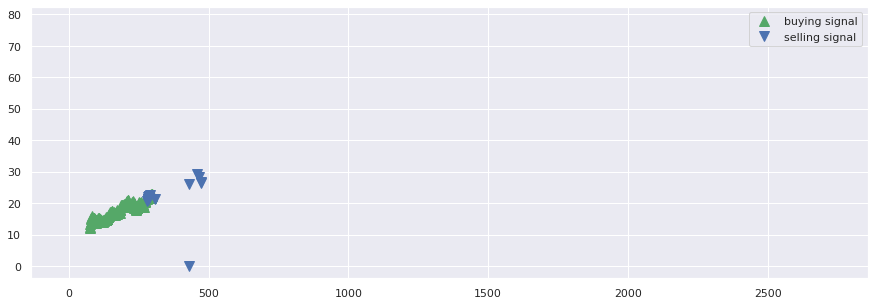

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


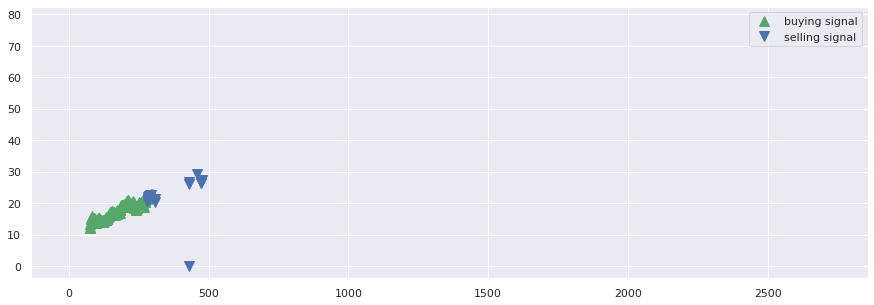

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


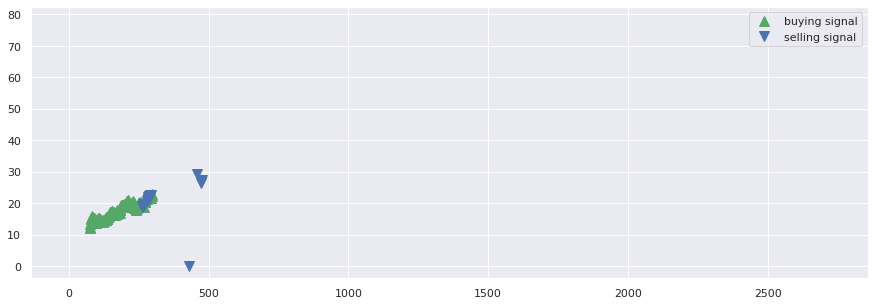

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


KeyboardInterrupt: ignored

In [108]:
for i in range(N):

  fig = plt.figure(figsize = (15,5))
  plt.plot(d, color='k', lw=2.)
  plt.plot(d, '^', markersize=10, color='g', label = 'buying signal',  markevery  = ([signal.cpu().numpy()[i,:,stock_num]==1]))
  plt.plot(d, 'v', markersize=10, color='b', label = 'selling signal', markevery  = ([signal.cpu().numpy()[i,:,stock_num]==-1]))
  # plt.title("Total Gains: ${:,.0f}".format(gains[i]))
  plt.legend()
  plt.show()